In [7]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd

In [8]:
#------ EQUATIONS FOR OUR THEORY ------

# NOTE: for now only for flat universe (need to change D_A(z))
# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    h , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_r = (2.47e-5*h**-2)*1.6949484   # last factor due to neutrinos
    
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    h , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_r = (2.47e-5*h**-2)*1.6949484   # last factor due to neutrinos
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    if np.abs(alpha_tilde) == 0 :
        E_LCDM = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
        return E_LCDM
    else:
        return np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))
    
# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Shift parameter
def R(cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]

# Acoustic scale
def l_A(cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]/\
           (scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), 2.5e-9, 1/(1+z_CMB(Omg_b,Omg_m,h)))[0])

In [9]:
def log_likelihood(theta, y, C_CMB):
    wb, wm, h , alpha = theta
    Omg_b = wb/h**2
    Omg_m = wm/h**2
    Omg_c = Omg_m - Omg_b
    cosmo = [h , Omg_b , Omg_c , 0 , alpha]
    model = [R(cosmo) , l_A(cosmo) , wb]
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(C_CMB)),np.transpose(y-model))

In [10]:
def log_prior(theta):
    wb, wm, h , alpha = theta
    # Limits due to paramterized form (https://arxiv.org/pdf/astro-ph/9510117.pdf, appendix E1/E2)
    # based on theory calculations that include ionization history
    if 0.0025 < wb < 0.25 and 0.0 < h < 1 and 0.025 < wm < 0.64 and 0 < alpha < 1e-1:
        return 0.0
    return -np.inf

In [11]:
def log_probability(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)

In [12]:
#get the data

# Choose the seed parameters.
wb_est = 0.2
wm_est = 0.5
h_est = 0.9
alpha_est = 1e-2

# Our data: y = [R , l_a , Omgb_hsquared] at z_CMB, and our Covariance matrix
C_CMB = 1e-8*np.array([[1598.9554 , 17112.007 , -36.311179],
              [17112.007 , 811208.45 , -494.79813],
              [-36.311179 , -494.79813 , 2.1242182]])

y = np.array([1.74963, 301.80845, 0.02237])


In [13]:
#np.savetxt("CMB_covmat.csv", C_CMB*1e8, delimiter=' & ', fmt='%2.2e', newline=' \\\\\n')

In [14]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [wb_est , wm_est , h_est, alpha_est] + 1e-3 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=( y, C_CMB)
)
sampler.run_mcmc(pos, 1000, progress=True);

 16%|████████████▍                                                                 | 159/1000 [00:56<04:09,  3.37it/s]/tmp/ipykernel_117292/290335576.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]
/tmp/ipykernel_117292/290335576.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]/\
 32%|████████████████████████▌                                                     | 315/1000 [01:46<04:46,  2.39it/s]/tmp/ipykernel_117292/290335576.py:56: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement

ValueError: Probability function returned NaN

In [15]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
labels = ["wb", "wm" , "h", "alpha"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

(0, 4)


/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (1) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


AssertionError: I don't believe that you want more dimensions than samples!

Text(0, 0.5, 'alpha_t')

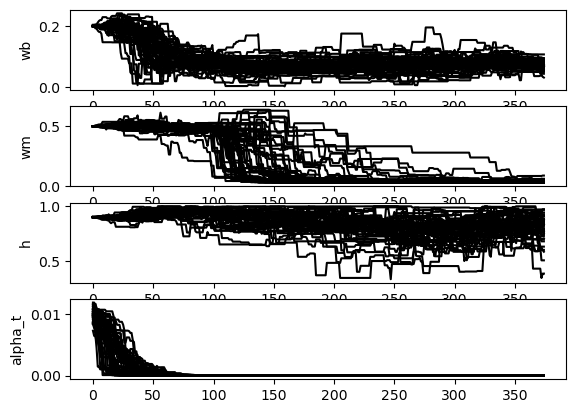

In [16]:
samples_chain = sampler.chain

fig, ax = plt.subplots(4)
for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")
    ax[3].plot(samples_chain[i, :, 3], color = "black")

ax[0].set_ylabel("wb")
ax[1].set_ylabel("wm")
ax[2].set_ylabel("h")
ax[3].set_ylabel("alpha_t")

In [17]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

IndexError: index -1 is out of bounds for axis 0 with size 0

wb,wm,h,alpha =  0.07387473227683142 0.02976485252839933 0.8830250993788726 3.343143565233302e-13


/tmp/ipykernel_117292/4146798311.py:24: RuntimeWarning: divide by zero encountered in true_divide
  z_val = 1/a_val - 1
/tmp/ipykernel_117292/4146798311.py:25: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(z_val, ((a_val**2)*E(1/a_val -1, c)*np.sqrt(3*(1 + R_b(wb_breaks)*a_val))), color = "b",label = "4DEGB")
/tmp/ipykernel_117292/290335576.py:15: RuntimeWarning: invalid value encountered in multiply
  return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
/tmp/ipykernel_117292/290335576.py:31: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))
/tmp/ipykernel_117292/4146798311.py:26: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(z_val, ((a_val**2)*E(1/a_val -1, c1)*np.sqrt(3*(1 + R_b(wb_breaks)*a_val))), color = "r", label = "LCDM")
/tmp/ipykernel_117292/290335576.py:28: Runtime

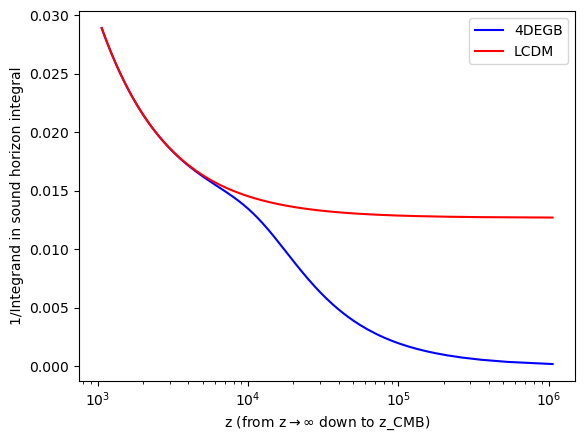

In [18]:
# Debugging

wb_breaks = samples_chain[i, :, 0][-1]
wm_breaks = samples_chain[i, :, 1][-1]
h_breaks = samples_chain[i, :, 2][-1]
alpha_breaks = samples_chain[i, :, 3][-1]

print("wb,wm,h,alpha = ", wb_breaks, wm_breaks, h_breaks, alpha_breaks)
c = [h_breaks , wb_breaks/h_breaks**2 , (wm_breaks-wb_breaks)/h_breaks**2 , 0 , alpha_breaks]
c1 = [h_breaks , wb_breaks/h_breaks**2 , (wm_breaks-wb_breaks)/h_breaks**2 , 0 , 0]

"""
print(1/(1+z_CMB(wb_breaks/h_breaks**2,wm_breaks/h_breaks**2,h_breaks)))

print(scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, c)*np.sqrt(3*(1 + R_b(wb_breaks)*x))),\
                           0 , 1/(1+z_CMB(wb_breaks/h_breaks**2,wm_breaks/h_breaks**2,h_breaks)))[0])

print(scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, c1)*np.sqrt(3*(1 + R_b(wb_breaks)*x))),\
                           0 , 1/(1+z_CMB(wb_breaks/h_breaks**2,wm_breaks/h_breaks**2,h_breaks)))[0])
"""
#print(scipy.integrate.quad(lambda x: 1/E(1/x -1, c), 0 , z_CMB(wb_breaks/h_breaks**2,wm_breaks/h_breaks**2,h_breaks))[0])

a_val = np.linspace(0, 1/(1+z_CMB(wb_breaks/h_breaks**2,wm_breaks/h_breaks**2,h_breaks)), int(1e3))
z_val = 1/a_val - 1
plt.plot(z_val, ((a_val**2)*E(1/a_val -1, c)*np.sqrt(3*(1 + R_b(wb_breaks)*a_val))), color = "b",label = "4DEGB")
plt.plot(z_val, ((a_val**2)*E(1/a_val -1, c1)*np.sqrt(3*(1 + R_b(wb_breaks)*a_val))), color = "r", label = "LCDM")

plt.xscale("log")
plt.legend()
plt.xlabel(r"z (from z$\rightarrow{} \infty$ down to z_CMB)")
plt.ylabel("1/Integrand in sound horizon integral")
plt.show()
# Note: problem seems to be that comoving sound horizon can't be evaluated at a = 0 because (a = 0)**2 * E(a = 0) = 0
# while it is a finite number in LCDM